##
Link to article :

https://arxiv.org/pdf/2407.14225#page=5.78

ref git : https://github.com/gardiens/MVA_24_25/blob/main/mva_geom/TD6/TP_6.ipynb


In [1]:
!jupyter server list


Currently running servers:


In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from slices import display_multi_slices, get_sdf_image
from tqdm.auto import tqdm
from synthetic_data import sphere_data, square_data
from marching_squares import get_img_marching_squares, display_multiple_shapes_sdf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"
device

device(type='cuda')

## Models for the point clouds ! 

In [3]:
class SirenLayer(nn.Module):
    def __init__(
        self, in_features, out_features, bias=True, is_first=False, omega_0=30
    ):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        ## Create the layer, and initialize it. You can do it in init_weights

        self.fc1 = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                ## Initialization of first layer type
                size = 1 / self.in_features
            else:
                size = np.sqrt(6 / self.in_features) / self.omega_0
                ## Other initialization
            self.fc1.weight.uniform_(-size, size)

    def forward(self, input):
        ## Logic
        return torch.sin(self.omega_0 * self.fc1(input))


input = torch.randn(2000, 3)
layer = SirenLayer(3, 256, is_first=True)
layer(input)
class SirenNet(torch.nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out, num_layers, skip=[], omega_0=30.0):
        super().__init__()
        self.num_layers = num_layers
        self.dim_hidden = dim_hidden
        self.skip = [i in skip for i in range(num_layers)]
        self.omega_0 = omega_0
        layers_list = []
        ## Create layer
        # first layer
        layers_list.append(
            SirenLayer(
                in_features=dim_in,
                out_features=dim_hidden,
                is_first=True,
                omega_0=omega_0,
            )
        )
        for k in range(1, num_layers):
            layers_list.append(
                SirenLayer(
                    in_features=dim_hidden,
                    out_features=dim_hidden,
                    is_first=False,
                    omega_0=omega_0,
                )
            )
        ## Last layer is a simple linear layer. Don't forget to intialize your weights as before!
        self.skip.append(False)
        self.last_layer = nn.Linear(dim_hidden, dim_out, bias=True)
        ## Init last layer
        size = np.sqrt(6 / dim_in) / self.omega_0
        with torch.no_grad():
            self.last_layer.weight.uniform_(-size, size)
        # create the network
        self.layers = nn.ModuleList(layers_list)

    def forward(self, x):
        ## Network logic
        ## You can ignore skip connections at the beginning
        #! The skip is never initialized so we don't know what is exactly this parameters,
        #! we assume it's a list of index where we have to skip the connection

        for index, layer in enumerate(self.layers):
            if self.skip[index]:
                x = x + layer(x)
            else:
                x = layer(x)
        output = self.last_layer(x)
        return output


input = torch.randn(2000, 3, device=device)
net = SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5, skip=[]).to(device)
net(input) 


tensor([[0.2445],
        [0.2327],
        [0.4671],
        ...,
        [0.0779],
        [0.4642],
        [0.3818]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Create the data

In [4]:
def sample_xt(batch_size, dim_space=2):
    ## Sample random points in space ([-1, 1]^2) and in time ([0, 1])
    list = [batch_size, dim_space]
    pts_random = (torch.rand(list, device=device)) * 2 - 1
    time_random = torch.rand(batch_size, device=device)

    return pts_random


## Loss functions 

In [5]:
def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad
def project_pc(net,input_pc):
    # apply F (n, fθ ) = n − d × ∇fθ (n, c)/||∇fθ (n, c)||2
    d= net(input_pc)
    grad= gradient(d, input_pc)
    return input_pc - d * grad/ torch.norm(grad, dim=1).view(-1,1)
input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
project_pc(net,input_pc).shape

/raid/home/bournez_pie/mva_geom/mva_geom_24/venv/lib/python3.8/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


torch.Size([2000, 3])

In [6]:
def alternative_random_choice(
    array: "torch.tensor", size: int, replace: bool = False, shape: int = 0
):
    weights = torch.ones(array.shape[shape])

    idx = torch.multinomial(weights, size, replacement=replace)
    return idx


In [7]:
# data should be 0 on the shape
def loss_data(sdf_pc):
    return torch.mean(sdf_pc**2)  # 

def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad


def loss_normalign(grad_pc, sample_nc):
    first_ps = torch.sum(sample_nc * grad_pc, dim=1)
    return ((1 - first_ps) ** 2).mean()
def loss_shape_data(net, pc, normals, batch_size=2000, dim_space=2):
    # sample batch size points and the corresponding normals
    idxs = alternative_random_choice(array=pc, size=batch_size, shape=0)
    sample_pc = pc[idxs]
    sample_pc.requires_grad = True
    sample_nc = normals[idxs]  #! Same idx !

    sdf_pc = net(sample_pc)
    # spatial gradients
    grad_pc = gradient(sdf_pc, sample_pc)[:, 0:2]

    ## compute loss
    loss_pc = 100 * loss_data(sdf_pc) + loss_normalign(grad_pc, sample_nc)
    return loss_pc

In [8]:
import numpy as np
import ot

2025-02-24 17:37:02.276367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-24 17:37:03.005652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Compute  Earth mover distance

In [9]:
import numpy as np
import ot
def compute_EMD(net,input_pc ,batch_size,dim_space=2):
    # we compute L(F (Ni, fθ ), Nj ). 
    # We use the EMD loss to compute the distance between the two point clouds

    # sample batch size points and the corresponding normals
    idxs = alternative_random_choice(array=input_pc, size=batch_size, shape=0)
    sample_pc = input_pc[idxs]
    Ni=project_pc(net,sample_pc)
    Nj=input_pc[alternative_random_choice(array=input_pc, size=batch_size, shape=0)]

    # compute the EMD loss
    # Uniform weights for each point (assuming equal weight)
    weights1 = torch.ones(len(Ni)) / len(Ni)
    weights1 = weights1.to(device)
    weights2 = torch.ones(len(Nj))/ len(Nj)
    weights2= weights2.to(device)
    cost_matrix=ot.dist(Ni, Nj).to(device)
    # Compute the Earth Mover's Distance (Optimal Transport)
    emd_value = ot.emd2(weights1, weights2, cost_matrix)
    emd_value = emd_value.to(device)
    return emd_value
        
input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
loss=compute_EMD(net,input_pc,2000)
loss.backward()#! THIS IS CUda compatible?!!
loss

tensor(0.0550, device='cuda:0', grad_fn=<ValFunctionBackward>)

### geomloss?

In [10]:
!pip install pykeops
!pip install geomloss

In [11]:
import torch
from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss

# Create some large point clouds in 3D
x = torch.randn(100000, 3, requires_grad=True).cuda()
y = torch.randn(200000, 3).cuda()

# Define a Sinkhorn (~Wasserstein) loss between sampled measures
loss = SamplesLoss(loss="sinkhorn")

L = loss(x, y)  # By default, use constant weights = 1/number of samples
g_x, = torch.autograd.grad(L, [x])  # GeomLoss fully supports autograd!
g_x

tensor([[ 2.6437e-07,  3.8552e-09,  7.2252e-08],
        [-9.1393e-08,  6.9712e-08, -1.4209e-07],
        [ 1.9025e-08, -2.9466e-08, -1.0401e-07],
        ...,
        [-1.6253e-06,  7.7854e-07,  6.8442e-06],
        [-7.4962e-08,  4.5509e-08,  1.8397e-09],
        [-2.6028e-08,  7.4939e-08, -2.6090e-07]], device='cuda:0')

In [12]:
import numpy as np
import geomloss
import torch
from geomloss import SamplesLoss
class EMD_loss(torch.nn.Module):
    def __init__(self):
        super(EMD_loss, self).__init__()
        self.loss=SamplesLoss(loss="sinkhorn")

    def forward(self, x, y):
        return self.loss(x, y)
def compute_EMD_geomloss(net,input_pc ,batch_size,loss,dim_space=2):
    # we compute L(F (Ni, fθ ), Nj ). 
    # We use the EMD loss to compute the distance between the two point clouds

    # sample batch size points and the corresponding normals
    idxs = alternative_random_choice(array=input_pc, size=batch_size, shape=0)
    sample_pc = input_pc[idxs]
    Ni=project_pc(net,sample_pc)
    Nj=input_pc[alternative_random_choice(array=input_pc, size=batch_size, shape=0)]

    # compute the EMD loss
    # Uniform weights for each point (assuming equal weight)   
    emd_value=loss(Ni, Nj)

    return emd_value
        
input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
loss_geom=EMD_loss()
compute_EMD_geomloss(net,input_pc,2000,loss_geom)

tensor(0.0232, device='cuda:0', grad_fn=<SelectBackward0>)

## Pull Loss

In [13]:
# we compute the second term of the loss
#! not sure this is the right computation, ! On devrait sample aléatoirement dans l'espace! 
def loss_geometric_consistency(net,input_pc,batch_size=2000,dim_space=2):
    idxs = alternative_random_choice(array=input_pc, size=batch_size, shape=0)
    sample_pc = input_pc[idxs]
    # We compute λ|Ni| * R(E)
    ni_barre=input_pc.shape[0]
    d= net(input_pc)
    nprime=project_pc(net,input_pc=input_pc)
    # compute |fθ (n, c)| − minn′ ∈F (Ni,fθ ) ||n − n′||2)
    # Compute pairwise Euclidean distances in a vectorized way
    dist_matrix = torch.cdist(input_pc, nprime)  # Shape: (N, N)
    
    # Get the minimum distance for each point
    min_distances, _ = torch.min(dist_matrix, dim=1)
    # Apply R(E) and compute sum
    #Compute E
    E = torch.abs(torch.norm(d) - min_distances.unsqueeze(1))  # Broadcasting

    regularization_term = torch.sum(nn.ReLU()(E))

    return 1/input_pc.shape[0] *regularization_term if input_pc.shape[0] > 0 else torch.tensor(0.0)

input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
net= SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5, skip=[]).to(device)
loss_geometric_consistency(net,input_pc)

tensor(8.1336, device='cuda:0', grad_fn=<MulBackward0>)

In [14]:
# we compute the second term of the loss
#! not sure this is the right computation, ! On devrait sample aléatoirement dans l'espace! 
def loss_geometric_consistency2(net,input_pc,batch_size=2000,dim_space=2):
    pts_random = sample_xt(batch_size, dim_space)
    pts_random.requires_grad = True

    
    nprime=project_pc(net,input_pc=pts_random)
    # compute |fθ (n, c)| − minn′ ∈F (Ni,fθ ) ||n − n′||2)
    # Compute pairwise Euclidean distances in a vectorized way
    dist_matrix = torch.cdist(nprime, input_pc)  # Shape: (N, N)
    
    # Get the minimum distance for each point
    min_distances, _ = torch.min(dist_matrix, dim=1)
    # Apply R(E) and compute sum
    #Compute E
    # E = torch.abs(torch.norm(d) - min_distances.unsqueeze(1))  # Broadcasting
    E= min_distances.sum()/min_distances.shape[0]

    regularization_term = E

    return E if input_pc.shape[0] > 0 else torch.tensor(0.0)

input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
net= SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5, skip=[]).to(device)
loss_geometric_consistency2(net,input_pc,dim_space=3)

tensor(0.1347, device='cuda:0', grad_fn=<DivBackward0>)

## compute the eikonal loss

In [15]:
def loss_eikonal_pts(grad_pts):
    ## Get the eikonal loss given spatial gradients
    return torch.mean(torch.abs(torch.norm(grad_pts, dim=1) - 1))

def loss_eikonal(net, batch_size, dim_space=2):
    ## Sample random points in space ([-1, 1]^2) and in time ([0, 1]), and compute eikonal loss
    pts_random = sample_xt(batch_size, dim_space)
    pts_random.requires_grad = True

    sdf_random = net(pts_random)

    grad_tot_random = gradient(sdf_random, pts_random)
    grad_spatial = grad_tot_random[:, 0:2]
    return loss_eikonal_pts(grad_spatial)


net = SirenNet(dim_in=2, dim_hidden=256, dim_out=1, num_layers=5).to(device)
loss_eikonal(net, 2000, 2)

tensor(2.8334, device='cuda:0', grad_fn=<MeanBackward0>)

# Complete loss

In [16]:
def evaluate_loss_cst_vf(
    net,
    pc,
    # normals,
    # hints_pc,
    # gtsdf,
    # vf,
    list_loss=[],
    lambda_pc=1,
    lambda_eik=2,
    lambda_hint=1,
    lambda_lse=1,
    batch_size=2000,
    lambda_gc=1,
    lambda_emd=1,
    dim_space=2,
):
    loss=0
    pc.requires_grad = True
    # they are all at time 0 ! 
    # Compute the EMD 
    # loss_EMD=compute_EMD(net=net,input_pc=pc,batch_size=batch_size)
    # Il faut voir ça comme la fonction qui "définit la surface"
    loss_EMD=compute_EMD_geomloss(net=net,input_pc=pc,batch_size=batch_size,loss=EMD_loss())
    list_loss[1].append(float(loss_EMD))
    loss+=    lambda_emd * loss_EMD

    # Compute the geometric consistency loss
    # c'est la partie du coup qui va régulariser en dhors du nuage dep oints !
    if lambda_gc>0:
        # loss_gc=loss_geometric_consistency(net=net,input_pc=pc)

        loss_gc=loss_geometric_consistency2(net=net,input_pc=pc,dim_space=pc.shape[-1])
        loss+=lambda_gc * loss_gc
        list_loss[2].append(float(loss_gc))

    # compute and store standard losses
    # loss_pc = loss_shape_data(net, pc, normals, batch_size)

    # loss_hint = loss_amb(net, hints_pc, gtsdf, batch_size)

    loss_eik = loss_eikonal(net, batch_size,dim_space=dim_space)
    list_loss[0].append(float(loss_eik))
    loss+=lambda_eik * loss_eik
    # loss_lse = loss_lse_eq(net, vf, batch_size)

    # append all the losses
    # lpc.append(float(loss_pc))
    
    # leik.append(float(loss_eik))
    # lemd.append(float(loss_EMD))
    # lgc.append(float(loss_gc))
    # lh.append(float(loss_hint))
    # llse.append(float(loss_lse))

    # sum the losses of reach of this set of points
    # loss = (
    #     # lambda_pc * loss_pc
    #     # lambda_eik * loss_eik+

    #     # + lambda_hint * loss_hint
    #     # + lambda_lse * loss_lse
    # )
    return loss
pc_input = torch.randn(10000, 3, device=device)
# pc_input.requires_grad = True
normals = torch.randn(10000, 2, device=device)
hints_pc = torch.randn(100000, 3, device=device)
gtsdf = torch.randn(100000, device=device)
vf = torch.randn(2, device=device)
net = SirenNet(dim_in=3, dim_hidden=256, dim_out=3, num_layers=5).to(device)
lpc = []
leik = []
lh = []
llse = []
lemd=[]
lgc=[]
list_loss=[[] for k in range(3)]
net = net.to(device)
evaluate_loss_cst_vf(net=net,
                     pc=pc_input,
                    #  normals=normals,
                    #  hints_pc=hints_pc,
                    #  gtsdf=gtsdf,
                    #  vf=vf,
                    #  lpc=lpc,
                    #  leik=leik,
                    #  lemd=lemd,
                    #  lgc=lgc,
                     dim_space=3,
                     list_loss=list_loss,
                     )

tensor(5.4107, device='cuda:0', grad_fn=<AddBackward0>)

# Display results

In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def display_result(f, resolution, filename=None, figsize=(14, 5),title=""):
    """
    Displays the values of the function f, evaluated over a regular grid 
    defined between -1 and 1 with a resolution of (resolution x resolution).
    """
    fig, ax = plt.subplots(figsize=figsize)  # Fix subplot creation
    time = 1
    i = time // 5
    j = time - i * 5
    t = 0.1 * time

    # Define device properly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create a grid of coordinates
    coords = torch.stack(list(torch.meshgrid([torch.linspace(-1, 1, resolution, device=device)] * 2, indexing='xy')), dim=2)
    coords = coords.reshape(-1, 2)  # Shape: (resolution*resolution, 2)
    print("coords shape before adding t:", coords.shape)

    # Ensure coordinates require gradients
    coords.requires_grad = True

    # Forward pass through the network
    sdf = f(coords)
    print("sdf shape before reshape:", sdf.shape)

    # Fix reshaping: Remove singleton dimension if present
    sdf = sdf.squeeze(-1).reshape(resolution, resolution)
    numpy_sdf = sdf.detach().cpu().numpy()

    # Processing SDF for visualization
    eps = 0.005
    numpy_sdf_max = 1 - np.maximum(numpy_sdf, np.zeros(numpy_sdf.shape))
    numpy_sdf_max = numpy_sdf_max - np.multiply(numpy_sdf_max, np.multiply(numpy_sdf <= eps, numpy_sdf >= -eps))

    numpy_sdf_min = 1 - np.maximum(-numpy_sdf, np.zeros(numpy_sdf.shape))
    numpy_sdf_min = numpy_sdf_min - np.multiply(numpy_sdf_min, np.multiply(numpy_sdf <= eps, numpy_sdf >= -eps))

    numpy_sdf_both = 1 - np.maximum(numpy_sdf, np.zeros(numpy_sdf.shape)) - np.maximum(-numpy_sdf, np.zeros(numpy_sdf.shape))
    numpy_sdf_both = numpy_sdf_both - np.multiply(numpy_sdf_both, np.multiply(numpy_sdf <= eps, numpy_sdf >= -eps))

    # Displaying the result
    ax.axis('off')
    ax.imshow(np.concatenate([numpy_sdf_min[:, :, np.newaxis], 
                              numpy_sdf_both[:, :, np.newaxis], 
                              numpy_sdf_max[:, :, np.newaxis]], axis=2))
    ax.contour(numpy_sdf, 10, colors='k', linewidths=0.4, linestyles='solid')

    # Show or save the figure
    plt.title(title)
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)
        plt.close()


# Run function

In [18]:
already_printed = []


def print_only_once(msg_name, msg):
    if msg_name not in already_printed:
        already_printed.append(msg_name)
        print(msg)
    return

In [ ]:
def optimize_nise_vf(
    net,
    pc0,
    # nc0,
    # hints0,
    # gtsdf0,
    # vf,
    # lpc,
    # leik,
    # lh,
    # llse,
    # lemd,
    # lgc,
    lambda_pc=1,
    lambda_eik=2,
    lambda_hint=1,
    lambda_lse=2,
    lambda_gc=1,
    lambda_emd=1,
    batch_size=2000,
    nepochs=100,
    plot_loss=True,
    list_loss=[],
    follow_paper=True
):
    # pc0, nc0, hints0, gtsdf0 are the input data at time  0
    # vf is the velocity field
    # lpc, leik, lh, llse are lists to store the losses
    # lambda_pc, lambda_eik, lambda_hint, lambda_lse are the weights of the losses
    optim = torch.optim.Adam(params=net.parameters(), lr=2e-5)

    if follow_paper:
        print("beware HARDCODED version")
    tinit = time.time()
    pbar = tqdm(total=nepochs, desc="Training")
    marqueur=False 
    for batch in range(nepochs):
        optim.zero_grad()
        if lambda_gc ==0:
            if marqueur:
                print("lambda_gc is null")
                marqueur=False 
        if lambda_emd ==0:
            print("lambda_emd is null")
        if lambda_pc ==0:
            print("lambda_pc is null")
        if lambda_eik ==0:
            print("lambda_eik is null")
        if follow_paper:
            # print("beware HARDCODED version")
            
            if batch<1500:
                lambda_gc=1/1500*(1500-batch)
            else:
                lambda_gc=0

        loss = evaluate_loss_cst_vf(
            net=net,
            pc=pc0,
            # normals=nc0,
            # hints_pc=hints0,
            # gtsdf=gtsdf0,
            # vf=vf,
            # lpc=lpc,
            # leik=leik,
            # lemd=lemd,
            # lgc=lgc,
            list_loss=list_loss,
            lambda_pc=lambda_pc,
            lambda_eik=lambda_eik,
            lambda_hint=lambda_hint,
            lambda_lse=lambda_lse,
            batch_size=batch_size,
            lambda_gc=lambda_gc,
            lambda_emd=lambda_emd,
            dim_space=pc0.shape[1],

        )
        loss.backward()
        optim.step()
        if batch % 100 == 99 or batch == 0:
            # print(f"Epoch {batch}/{nepochs} - loss : {loss.item()}")
            pbar.set_postfix({"loss": loss.item()})
        pbar.update(1)
        if batch %1000==0:
            display_result(net, resolution=200, figsize=(14, 5))
    tend = time.time()

    print("Optimizing NN took", "{:.2f}".format(tend - tinit), "s.")

# actual data :
For work only 2D canonical shape(?)

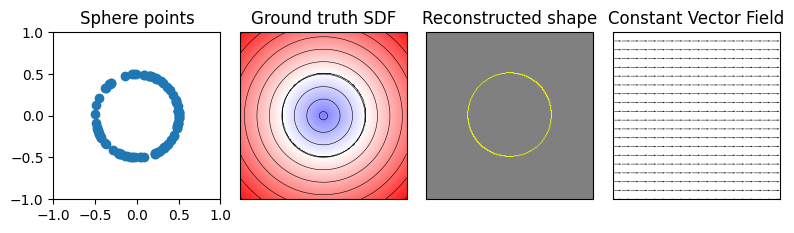

In [20]:
pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(
    10000, 100000
)

# constant vector field (a single vector)
vf = torch.tensor([0.3, 0.0], device=device)


fig, axs = plt.subplots(1, 4, figsize=(8, 15))
pc_numpy = pc0.detach().cpu().numpy()
axs[0].scatter(pc_numpy[::100, 0], pc_numpy[::100, 1])
axs[0].set_aspect(1.0 / axs[0].get_data_ratio(), adjustable="box")
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_title("Sphere points")
sdf_numpy = sdf_coords.detach().cpu().numpy()
axs[1].imshow(get_sdf_image(sdf_numpy))
axs[1].contour(sdf_numpy, 10, colors="k", linewidths=0.4, linestyles="solid")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Ground truth SDF")
rec_img = get_img_marching_squares(sdf_numpy)
axs[2].imshow(rec_img)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Reconstructed shape")


def get_vector_field_meshgrid(X_value, Y_value):
    # Create a grid of points
    x = np.linspace(-1, 1, 20)
    y = np.linspace(-1, 1, 20)
    X, Y = np.meshgrid(x, y)

    # Define the constant vector field (e.g., constant vector [1, 1] everywhere)
    U = np.ones_like(X) * X_value / (10 * max(X_value, Y_value))  # constant x-component
    V = np.ones_like(Y) * Y_value / (10 * max(X_value, Y_value))  # constant y-component
    return X, Y, U, V


X, Y, U, V = get_vector_field_meshgrid(vf[0].item(), vf[1].item())
axs[3].quiver(X, Y, U, V, angles="xy", scale_units="xy", scale=1)
axs[3].set_xlim((-1, 1))
axs[3].set_ylim((-1, 1))
axs[3].set_aspect("equal")
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[3].set_title("Constant Vector Field")
axs[3].grid()
plt.tight_layout()
plt.show()

In [21]:
npl = 128
depth = 3
true_net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
    device
)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]
list_loss=[[] for k in range(10)]


beware HARDCODED version


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


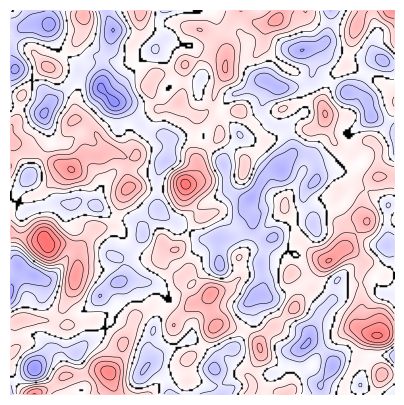

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


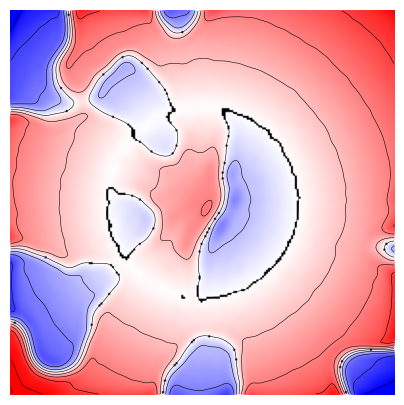

TypeError: print_only_once() missing 1 required positional argument: 'msg'

In [22]:

npl = 128
depth = 3
true_net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
    device
)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]
list_loss=[[] for k in range(10)]
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
nepochs = 10000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    # hints0=pts_hintst0,
    # gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    lambda_pc=1,# not used,
    lambda_eik=0.001, # eikonal,
    lambda_hint=1, # ot used,
    lambda_lse=2, # not used,
    lambda_gc=0.0001, #geometric consistency,
    lambda_emd=1, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    list_loss=list_loss,
)

torch.save(true_net, "net_vf_{}_{}.net".format(npl, depth))

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


/tmp/ipykernel_3931412/2987464184.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net2= torch.load("net_vf_128_3.net")


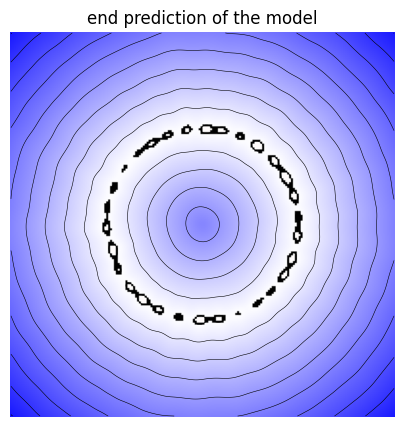

In [ ]:
net2= torch.load("net_vf_128_3.net")
display_result(true_net, resolution=200, figsize=(14, 5),title="end prediction of the model")

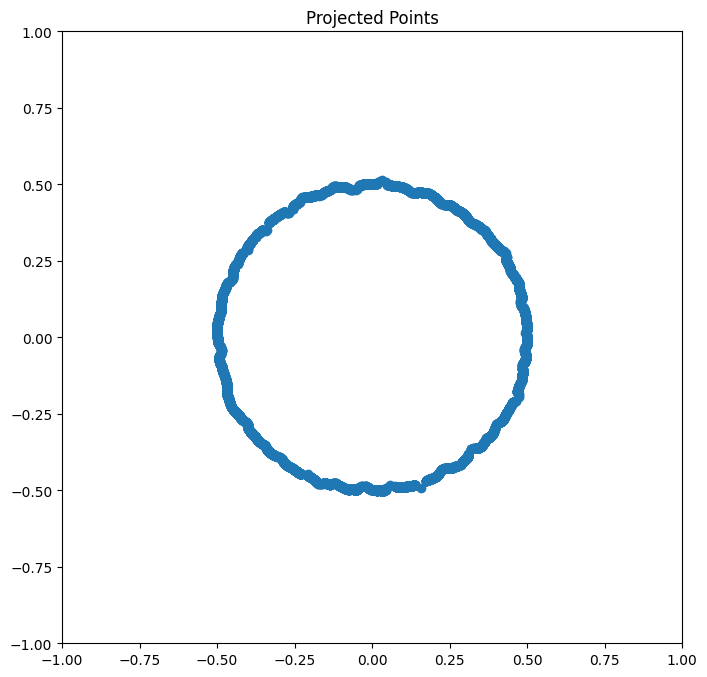

In [ ]:
import torch
import matplotlib.pyplot as plt

def display_projection(net, input_pc):
    """
    Projects the input point cloud onto a learned surface using the SDF network 
    and displays the projected points in 2D.
    """
    # Compute signed distance and gradient
    d = net(input_pc)
    grad = gradient(d, input_pc)
    
    # Compute the projected points
    S_projected = input_pc - d * grad / torch.norm(grad, dim=1, keepdim=True)

    # Display as 2D scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))  # Fix subplot initialization
    pc_numpy = S_projected.detach().cpu().numpy()

    ax.scatter(pc_numpy[:, 0], pc_numpy[:, 1])
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable="box")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_title("Projected Points")

    plt.show()

pc_t0 = pc0.clone().to(device)
pc_t0.requires_grad = True
display_projection(net2,pc_t0)


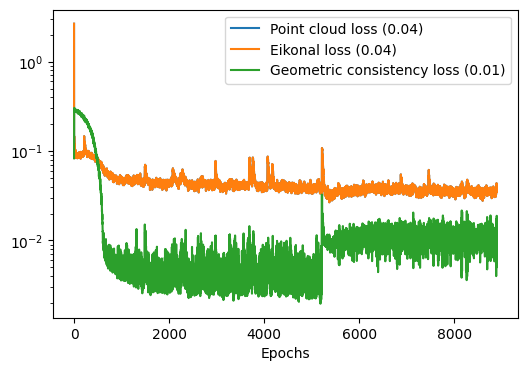

In [ ]:
def display_loss(list_loss):
    lgc=list_loss[2]
    lpc=list_loss[0]
    leik=list_loss[0]
    plt.figure(figsize=(6, 4))
    plt.yscale("log")
    plt.plot(lpc, label="Point cloud loss ({:.2f})".format(lpc[-1]))
    plt.plot(leik, label="Eikonal loss ({:.2f})".format(leik[-1]))
    plt.plot(lgc, label="Geometric consistency loss ({:.2f})".format(lgc[-1]))
    plt.xlabel("Epochs")
    plt.legend()
display_loss(list_loss)